Copyright (c) 2020, salesforce.com, inc.  
All rights reserved.  
SPDX-License-Identifier: BSD-3-Clause  
For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause

# Apresentação do Foundation Framework

* Simulador de modelos econômicos desenvolvido na plataforma AI Economist.
* Framework baseado em Reinforcement Learning para construção de um sistema de recomendação de políticas públicas.
* Métricas de eficiência podem ser: 
 * Sustentabilidade do modelo.
 * Produtividade.
 * Equalidade.

* Regras de "economic thinking".


Este material é baseado no trabalho de:

> ZHENG, Stephan et al. The AI Economist: Improving Equality and Productivity with AI-Driven Tax Policies. arXiv preprint arXiv:2004.13332, 2020.

Os códigos são uma adaptação do original:

* https://github.com/salesforce/ai-economist

# Qual o domínio da simulação?

![Foundation snapshot](https://github.com/salesforce/ai-economist/blob/master/tutorials/assets/foundation_snapshot_rendered.jpg?raw=1)

* Os múltiplos agentes, que estão inseridos no ambiente.
* Ambiente onde os agentes estão inseridos e possuem características definidas pelo problema em análise.
* Métodos de integração, nos quais os agentes se comunicar, trocar informações e podem coordenar ações.
* Regras de ação no amiente, nos quais os agentes se organizam e devem agir de acordo com as regras estabelecidas pelo problema e pelo ambiente.

# Qual a arquitetura que organiza os agentes?

* Sistemas com foco na resolução de problemas de forma colaborativa e distribuída. 
* Nesse tipo, os agentes devem resolver os objetivos do problema de forma cooperativa, interagindo entre si.

* A topologia de formação do sistema:
 * Distribuída (conhecido como peer-to-peer), onde não existe uma hierarquia e os agentes podem tomar decisões independentes sem a supervisão de outros agentes.

# Como os agentes tomam decisões?

* "Markov Decision Processes".
* Aprendizado por reforço.
* Tentam maximizar a recompensa das ações.

# Comunicação e coordenação

* O sistema pode ser modelado para uma ação independente ou coletiva.
* Podem trocar informações para a resolução de um problema coletivo.

# Atuação

* Cada agente executa suas ações no cenário.
* Existe um conjunto de regras que delimitam as ações.


# Para criar um ambiente de simulação:

1. Definir "Markov Decision Processes".
2. Criar o ambiente de simulação, definido por um cenário.
3. Atividade dos agentes na simulação.
4. Visualizar a atuação dos agentes.

## Exemplo prático:


* Projeto open-source: https://github.com/salesforce/ai-economist

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

In [ ]:
if IN_COLAB:
    ! git clone https://github.com/salesforce/ai-economist.git 
    % cd ai-economist
    ! pip install -e .
else:
    ! pip install ai-economist

In [ ]:
# Import foundation
from ai_economist import foundation

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
if IN_COLAB:
    from tutorials.utils import plotting  # plotting utilities for visualizing env state
else:
    from utils import plotting

# Criando um ambiente (Scenario)

Documentação:
> Each Scenario is stateful and implements two main methods:
- __step__, which advances the simulation to the next state, and 
- __reset__, which puts the simulation back in an initial state.


Ações dos agentes:

* Construir uma casa.
* Coletar recursos (madeira e pedra).

In [ ]:
# Define the configuration of the environment that will be built

env_config = {
    # ===== SCENARIO CLASS =====
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    'scenario_name': 'layout_from_file/simple_wood_and_stone',
    
    # ===== COMPONENTS =====
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    #   "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #   {component_kwargs} is a dictionary of kwargs passed to the Component class
    # The order in which components reset, step, and generate obs follows their listed order below.
    'components': [
        # (1) Building houses
        ('Build', {'skill_dist': "pareto", 'payment_max_skill_multiplier': 3}),
        # (2) Trading collectible resources
        ('ContinuousDoubleAuction', {'max_num_orders': 5}),
        # (3) Movement and resource collection
        ('Gather', {}),
    ],
    
    # ===== SCENARIO CLASS ARGUMENTS =====
    # (optional) kwargs that are added by the Scenario class (i.e. not defined in BaseEnvironment)
    'env_layout_file': 'quadrant_25x25_20each_30clump.txt',
    'starting_agent_coin': 10,
    'fixed_four_skill_and_loc': True,
    
    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    'n_agents': 4,          # Number of non-planner agents (must be > 1)
    'world_size': [25, 25], # [Height, Width] of the env world
    'episode_length': 1000, # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': True,
    
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks': True,
}

In [ ]:
env = foundation.make_env_instance(**env_config)

# Executando a simulação

## Criando um agente

Documentação:
> The Agent class holds the state of agents in the simulation. Each Agent instance represents a _logical_ agent.
_Note that this might be separate from a Policy model that lives outside the Scenario and controls the Agent's behavior._

In [ ]:
env.get_agent(0)

## Definindo as regras

Documentação:
> Each Agent needs to choose which actions to execute using a __policy__.
Agents might not always be allowed to execute all actions. For instance, a mobile Agent cannot move beyond the boundary of the world. Hence, in position (0, 0), a mobile cannot move "Left" or "Down". This information is given by a mask, which is provided under ```obs[<agent_id_str>]["action_mask"]``` in the observation dictionary ```obs``` returned by the scenario.

In [ ]:
# Note: The code for sampling actions (this cell), and playing an episode (below) are general.  
# That is, it doesn't depend on the Scenario and Component classes used in the environment!

def sample_random_action(agent, mask):
    """Sample random UNMASKED action(s) for agent."""
    # Return a list of actions: 1 for each action subspace
    if agent.multi_action_mode:
        split_masks = np.split(mask, agent.action_spaces.cumsum()[:-1])
        return [np.random.choice(np.arange(len(m_)), p=m_/m_.sum()) for m_ in split_masks]

    # Return a single action
    else:
        return np.random.choice(np.arange(agent.action_spaces), p=mask/mask.sum())

def sample_random_actions(env, obs):
    """Samples random UNMASKED actions for each agent in obs."""
        
    actions = {
        a_idx: sample_random_action(env.get_agent(a_idx), a_obs['action_mask'])
        for a_idx, a_obs in obs.items()
    }

    return actions

In [ ]:
# reinicializando o cenário
obs = env.reset()

## Cada ação realizada

Documentação:
> Then, we call __step__ to advance the state and advance time by one tick.

In [ ]:
actions = sample_random_actions(env, obs)
obs, rew, done, info = env.step(actions)

## Analizando as ações

Documentação:
> Each observation is a dictionary that contains information for the $N$ agents and (optionally) social planner (with id "p").

In [ ]:
obs.keys()

dict_keys(['0', '1', '2', '3', 'p'])

In [ ]:
# os estados do ambiente e dos agentes a cada tempo T de ação
for key, val in obs['0'].items(): 
    print("{:50} {}".format(key, type(val)))

world-map                                          <class 'numpy.ndarray'>
world-idx_map                                      <class 'numpy.ndarray'>
world-loc-row                                      <class 'float'>
world-loc-col                                      <class 'float'>
world-inventory-Coin                               <class 'float'>
world-inventory-Stone                              <class 'float'>
world-inventory-Wood                               <class 'float'>
time                                               <class 'list'>
Build-build_payment                                <class 'numpy.float64'>
Build-build_skill                                  <class 'float'>
ContinuousDoubleAuction-market_rate-Stone          <class 'numpy.float64'>
ContinuousDoubleAuction-price_history-Stone        <class 'numpy.ndarray'>
ContinuousDoubleAuction-available_asks-Stone       <class 'numpy.ndarray'>
ContinuousDoubleAuction-available_bids-Stone       <class 'numpy.ndarray'>
Continu

## Recompensa das ações


In [ ]:
for agent_idx, reward in rew.items(): 
    print("{:2} {:.3f}".format(agent_idx, reward))

0  -0.263
1  -0.053
2  -0.263
3  -0.053
p  0.000


## Finalizando a simulação

Documentação:
> The __done__ object is a dictionary that by default records whether all agents have seen the end of the episode. The default criterion for each agent is to 'stop' their episode once $H$ steps have been executed. Once an agent is 'done', they do not change their state anymore. So, while it's not currently implemented, this could be used to indicate that the episode has ended *for a specific Agent*.

In [ ]:
done

{'__all__': False}

# Executando a simulação

* Para cada tempo T de simulação, cria um gráfico do ambiente.

In [ ]:
def do_plot(env, ax, fig):
    """Plots world state during episode sampling."""
    plotting.plot_env_state(env, ax)
    ax.set_aspect('equal')
    display.display(fig)
    display.clear_output(wait=True)

def play_random_episode(env, plot_every=100, do_dense_logging=False):
    """Plays an episode with randomly sampled actions.
    
    Demonstrates gym-style API:
        obs                  <-- env.reset(...)         # Reset
        obs, rew, done, info <-- env.step(actions, ...) # Interaction loop
    
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Reset
    obs = env.reset(force_dense_logging=do_dense_logging)

    # Interaction loop (w/ plotting)
    for t in range(env.episode_length):
        actions = sample_random_actions(env, obs)
        obs, rew, done, info = env.step(actions)

        if ((t+1) % plot_every) == 0:
            do_plot(env, ax, fig)

    if ((t+1) % plot_every) != 0:
        do_plot(env, ax, fig)        

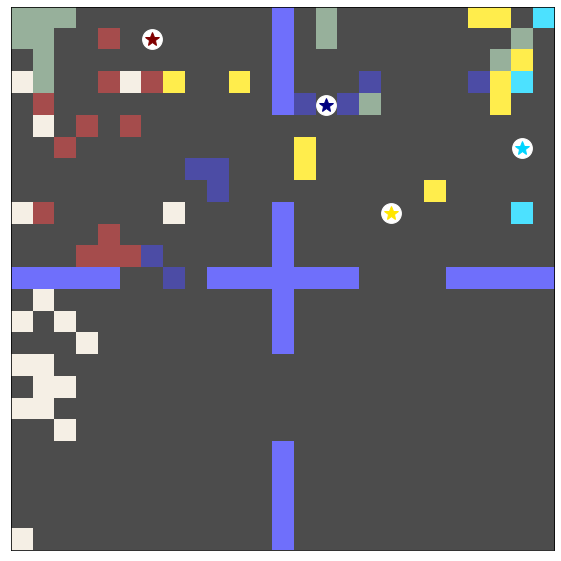

In [ ]:
play_random_episode(env, plot_every=20) # plot_every=100


Documentação:
> We see four agents (indicated by a circled __\*__) that move around in the 2-dimensional world. Light brown cells contain Stone, green cells contain Wood. Each agent can build Houses, indicated by corresponding colored cells. Water tiles (blue squares), which prevent movement, divide the map into four quadrants.

# Visualização geral da simulação

Documentação:
> Environments built with Foundation provide a couple tools for logging. Perhaps the most useful are **dense logs**. When you reset the environment, you can tell it to create a dense log for the new episode. This will store Agent states at each point in time along with any Component-specific dense log information (say, about builds, trades, etc.) that the Components provide. In addition, it will periodically store a snapshot of the world state.

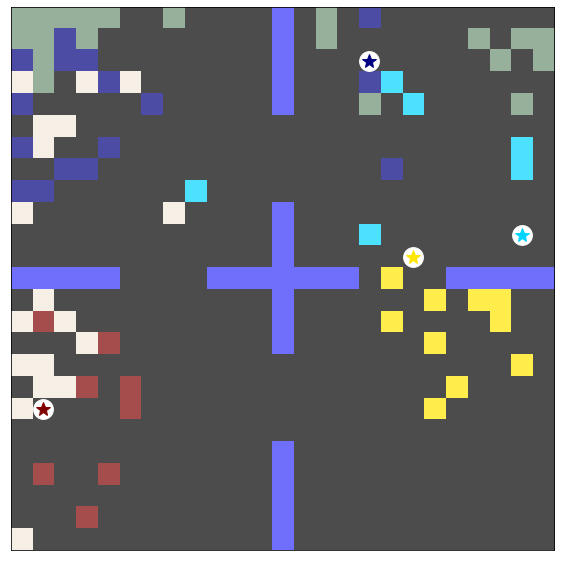

In [ ]:
# Play another episode. This time, tell the environment to do dense logging
play_random_episode(env, plot_every=10, do_dense_logging=True)

# Grab the dense log from the env
dense_log = env.previous_episode_dense_log

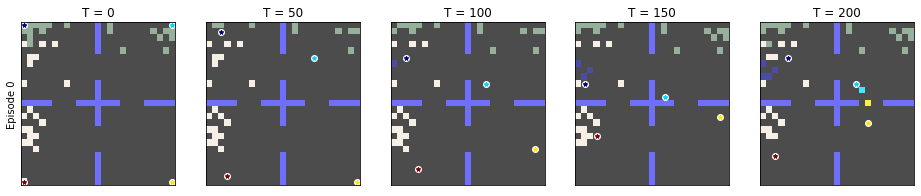

In [ ]:
# Show the evolution of the world state from t=0 to t=200
fig = plotting.vis_world_range(dense_log, t0=0, tN=200, N=5)

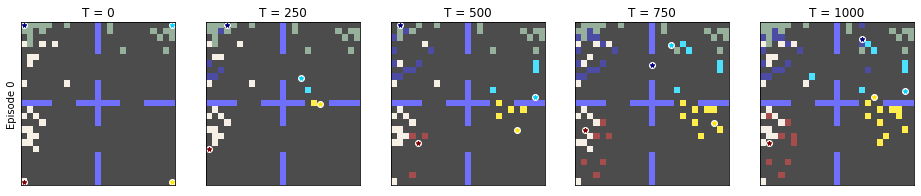

In [ ]:
# Show the evolution of the world state over the full episode
fig = plotting.vis_world_range(dense_log, N=5)

_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 ____
Cost (Wood)    :   5.90 (n= 72) |   5.28 (n= 60) |   5.22 (n= 72) |   4.83 (n= 63)
Cost (Stone)   :   5.89 (n= 28) |   6.78 (n= 36) |   6.67 (n= 49) |   7.20 (n= 35)

Income (Wood)  :   4.89 (n= 85) |   5.37 (n= 65) |   5.24 (n= 62) |   6.04 (n= 55)
Income (Stone) :   6.70 (n= 27) |   6.22 (n= 27) |   6.87 (n= 38) |   6.75 (n= 56)
Income (Build) :  16.47 (n= 16) |  11.33 (n=  6) |  22.25 (n= 10) |  13.27 (n=  8)


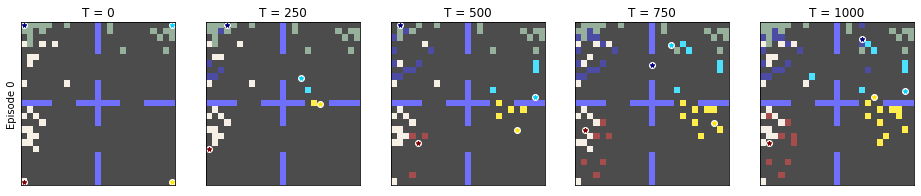

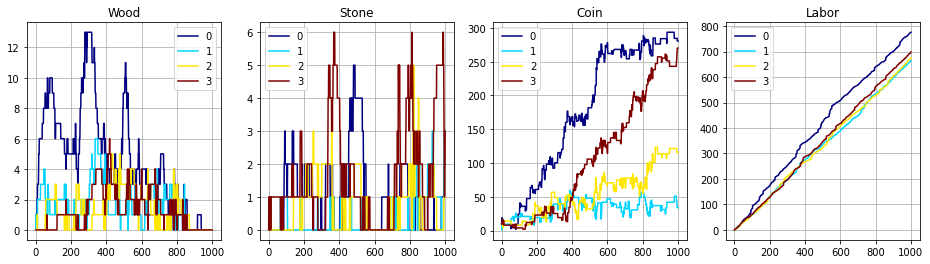

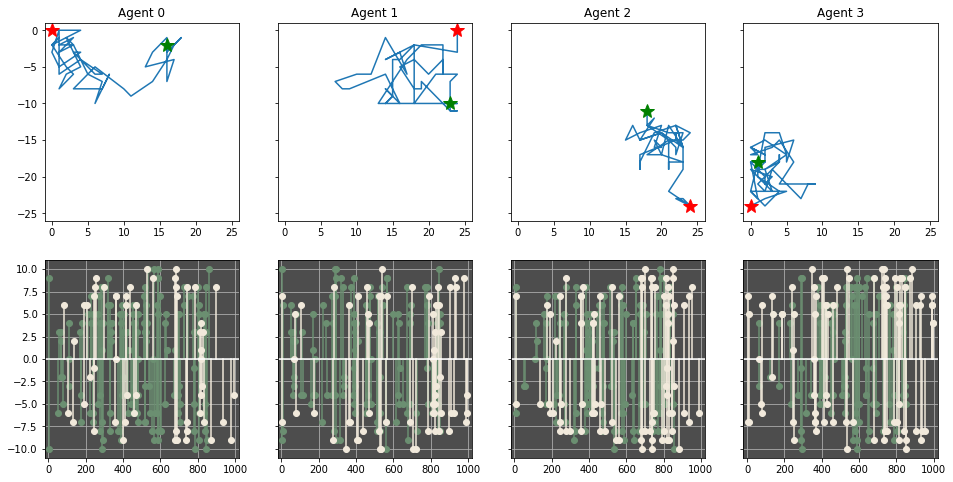

In [ ]:
# Use the "breakdown" tool to visualize the world state, agent-wise quantities, movement, and trading events
plotting.breakdown(dense_log);